In [26]:
from CollabFilterOneVectorPerItem import *
from train_valid_test_loader import *
import pickle
import matplotlib.pyplot as plt

In [27]:
# Load dataset
train_tuple, valid_tuple, test_tuple, n_users, n_items = load_train_valid_test_datasets()

In [28]:
def train_and_evaluate(k, alpha, n_epochs=10, step_size=0.1, batch_size=10000):
    model = CollabFilterOneVectorPerItem(
        n_epochs=n_epochs, 
        batch_size=batch_size, 
        step_size=step_size, 
        n_factors=k, 
        alpha=alpha
    )
    model.init_parameter_dict(n_users, n_items, train_tuple)
    model.fit(train_tuple, valid_tuple)

    # Save traces for validation error
    traces = {
        'trace_mae_train': model.trace_mae_train,
        'trace_mae_valid': model.trace_mae_valid
    }
    
    # Evaluate performance
    valid_perf = model.evaluate_perf_metrics(*valid_tuple)
    test_perf = model.evaluate_perf_metrics(*test_tuple)
    
    return model.param_dict, valid_perf, test_perf, traces

In [33]:
alphas = [0.0, 0.1, 1.0]
ks = [2, 10, 50]
results = {}

# Train models for each K and alpha
for k in ks:
    results[k] = {}
    for alpha in alphas:
        print(f"Training with K={k}, alpha={alpha}")
        params, valid_perf, test_perf, traces = train_and_evaluate(k=k, alpha=alpha, n_epochs=50, step_size=50, batch_size=100)
        results[k][alpha] = {
            "params": params,
            "valid_perf": valid_perf,
            "test_perf": test_perf,
            "traces": traces,
        }

with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

Training with K=2, alpha=0.0
epoch       0.000 | loss_total     0.13000 | train_MAE     3.53058 | valid_MAE     3.54504 | grad_wrt_mu     0.06840 | grad_wrt_b_per_user     0.00007 | grad_wrt_c_per_item     0.00004 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.001 | loss_total     0.01407 | train_MAE     0.95444 | valid_MAE     0.95576 | grad_wrt_mu     0.00018 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.003 | loss_total     0.01384 | train_MAE     0.95259 | valid_MAE     0.95387 | grad_wrt_mu     0.00140 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.004 | loss_total     0.01208 | train_MAE     0.94414 | valid_MAE     0.94477 | grad_wrt_mu     0.00096 | grad_wrt_b_per_user     0.00002 | grad_wrt_c_per_item     0.00001 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.126 | loss_total 

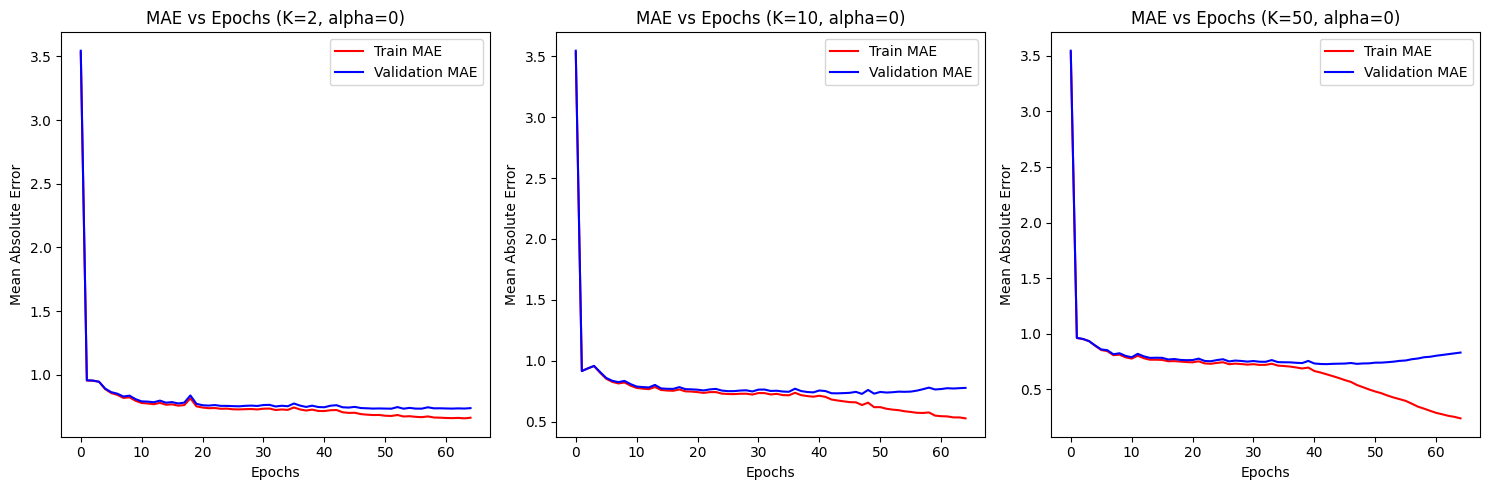

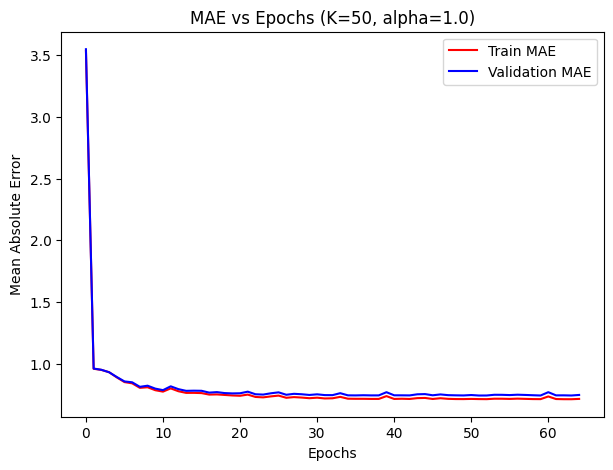

    K  Best Alpha  Validation MAE  Test MAE
0   2         0.0        0.735663  0.729439
1  10         1.0        0.750382  0.741484
2  50         1.0        0.751219  0.749788


In [34]:
# Load the results
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract the best results
ks = [2, 10, 50]
best_results = {}
alphas = [0.0, 0.1, 1.0]

for k in ks:
    best_alpha = min(alphas, key=lambda alpha: results[k][alpha]["valid_perf"]["mae"])
    best_results[k] = {
        "alpha": best_alpha,
        "valid_perf": results[k][best_alpha]["valid_perf"],
        "test_perf": results[k][best_alpha]["test_perf"],
        "traces": results[k][best_alpha]["traces"]
    }

# Part 1A: Plotting train and validation MAE for alpha=0 (K=2, 10, 50)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, k in zip(axes, ks):
    trace_train = results[k][0.0]['traces']['trace_mae_train']
    trace_valid = results[k][0.0]['traces']['trace_mae_valid']
    ax.plot(range(len(trace_train)), trace_train, color='red', label="Train MAE")
    ax.plot(range(len(trace_valid)), trace_valid, color='blue', label="Validation MAE")
    ax.set_title(f"MAE vs Epochs (K={k}, alpha=0)")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Mean Absolute Error")
    ax.legend()
plt.tight_layout()
plt.show()

# Part 1B: Plotting train and validation MAE for K=50 with the best alpha
best_alpha_k50 = best_results[50]["alpha"]
trace_train_k50 = results[50][best_alpha_k50]['traces']['trace_mae_train']
trace_valid_k50 = results[50][best_alpha_k50]['traces']['trace_mae_valid']

plt.figure(figsize=(7, 5))
plt.plot(range(len(trace_train_k50)), trace_train_k50, color='red', label="Train MAE")
plt.plot(range(len(trace_valid_k50)), trace_valid_k50, color='blue', label="Validation MAE")
plt.title(f"MAE vs Epochs (K=50, alpha={best_alpha_k50})")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

# Create and print table with best validation and test MAE for each K
table_data = []
for k in ks:
    best_alpha = best_results[k]["alpha"]
    valid_mae = best_results[k]["valid_perf"]["mae"]
    test_mae = best_results[k]["test_perf"]["mae"]
    table_data.append({"K": k, "Best Alpha": best_alpha, "Validation MAE": valid_mae, "Test MAE": test_mae})

results_df = pd.DataFrame(table_data)
print(results_df)